## 기존 코드에서 검출되는 네 모서리 확인하기

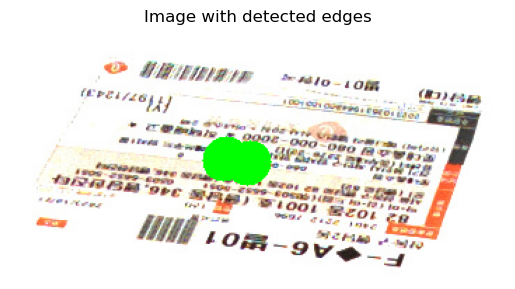

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def find_document_edges(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(gray, 75, 200)
    contours, _ = cv2.findContours(edged, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    for contour in contours:
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
        if len(approx) == 4:
            return approx
    return None

# 테스트 이미지 로드
image = cv2.imread('crops/invoice/CAM 20231028070900_5.jpg')
edges = find_document_edges(image)

if edges is not None:
    for point in edges:
        cv2.circle(image, tuple(point[0]), 15, (0, 255, 0), -1)

# 이미지를 BGR에서 RGB로 변환 (matplotlib는 RGB 형식을 사용)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 이미지를 matplotlib를 사용하여 표시
plt.imshow(image)
plt.title("Image with detected edges")
plt.axis('off')  # 축을 숨깁니다.
plt.show()

# 컨투어링 방법 1을 이용한 역원근 (기존)

Corners of the document: [[[ 86 565]]

 [[ 58 582]]

 [[ 74 608]]

 [[102 592]]]


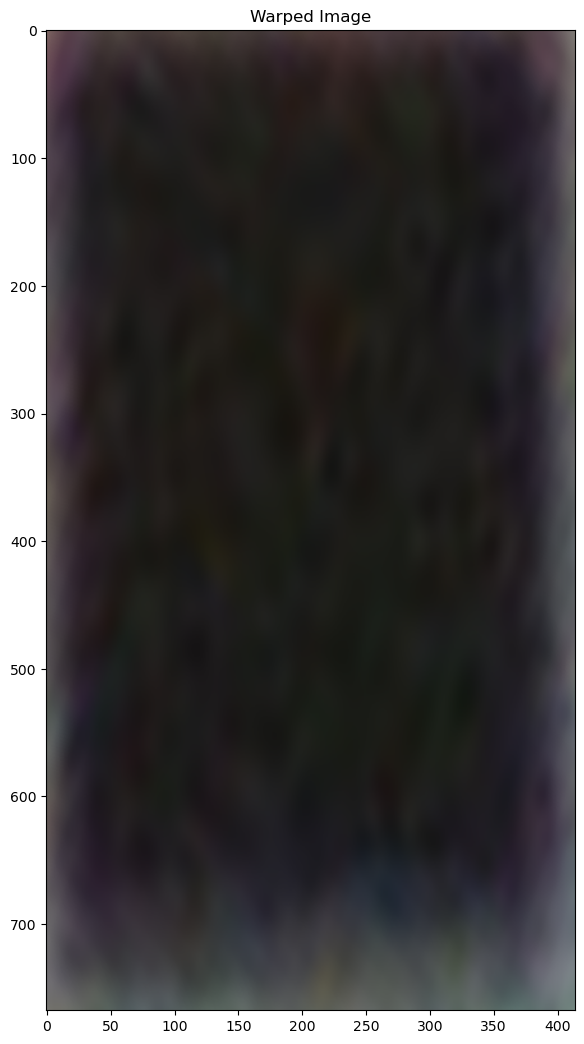

In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def order_points(pts):
    # Initialize a list of coordinates that will be ordered
    rect = np.zeros((4, 2), dtype="float32")
    
    # The top-left point will have the smallest sum, the bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    # The top-right point will have the smallest difference, the bottom-left will have the largest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect

def find_document_edges(image):
    # 그레이스케일 변환
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # 가우시안 블러 적용
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Canny 에지 검출
    edged = cv2.Canny(blurred, 50, 150)
    
    # 닫기 연산을 위한 구조적 요소 생성 (5x5 크기의 사각형)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

    # 닫기 연산 적용
    closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(edged, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    for contour in contours:
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
        if len(approx) == 4:
            return approx
    return None

#이미지 내에서 문서의 가장자리를 기준으로 이미지를 변환(warp)
def warp_perspective(image, edges):
    pts = edges.reshape(4, 2) #edges는 4개의 점으로 이루어진 배열, reshape를 통해 (4,2)로 변환
    rect = order_points(pts) #사각형의 네 모서리의 점의 정확한 위치 찾기
    (tl, tr, br, bl) = rect
    maxWidth, maxHeight = image.shape[1], image.shape[0] #변환된 이미지의 너비와 높이는 입력 이미지의 크기로 설정
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight), flags=cv2.INTER_CUBIC) #cv2.INTER_CUBIC 보간법 사용하여 원근 변환 수행
    return warped #문서 이미지를 변환
# 이미지 로드
image_path = 'crops/invoice/CAM 20231028070900_1.jpg'
image = cv2.imread(image_path)

# 모서리 점 찾기
corners= find_document_edges(image)

# 원근 변환 수행
warped_image = warp_perspective(image, corners)

# 모서리 점 출력
print("Corners of the document:", corners)

# 결과 이미지 출력
plt.figure(figsize=(15, 15))


plt.subplot(122)
plt.title('Warped Image')
plt.imshow(cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB))

plt.show()


# 컨투어링 방법 2를 이용한 역원근

Corners of the document: [[  -6.   12.]
 [ 510.  -65.]
 [ 662.  944.]
 [ 145. 1021.]]
Area of the document: 533357.744229893
Total image area: 678993
Document area ratio: 78.55%


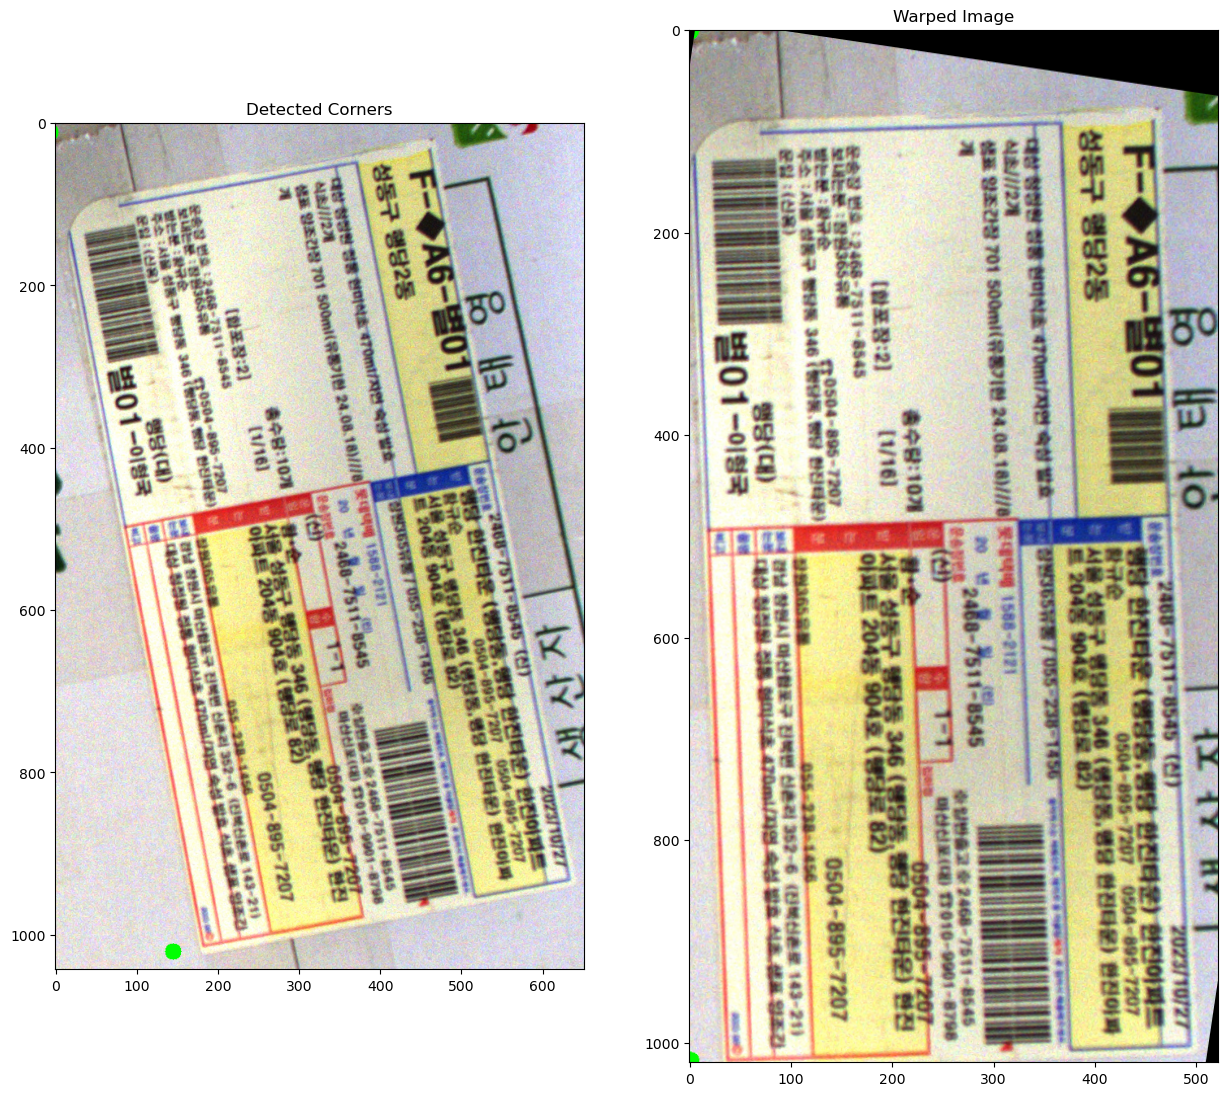

In [54]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def order_points(pts):
    # Initialize a list of coordinates that will be ordered
    rect = np.zeros((4, 2), dtype="float32")
    
    # The top-left point will have the smallest sum, the bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    # The top-right point will have the smallest difference, the bottom-left will have the largest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect

def find_document_edges(image):
    # 그레이스케일 변환
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # 가우시안 블러 적용
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Canny 에지 검출
    edged = cv2.Canny(blurred, 50, 150)
    
    # 닫기 연산을 위한 구조적 요소 생성 (5x5 크기의 사각형)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

    # 닫기 연산 적용
    closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)

    # 컨투어 찾기
    contours, _ = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 가장 큰 컨투어 찾기 (운송장 테두리로 간주)
    c = max(contours, key=cv2.contourArea)

    # 최소 외접 사각형 찾기
    rect = cv2.minAreaRect(c)
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    # 이미지에 모서리 점 표시
    for point in box:
        cv2.circle(image, tuple(point), 10, (0, 255, 0), -1)
    
    return order_points(box), image

def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    
    # compute the width of the new image, which will be the maximum distance between bottom-right and bottom-left x-coordinates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    
    # compute the height of the new image, which will be the maximum distance between the top-right and bottom-right y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    
    # now that we have the dimensions of the new image, construct the set of destination points to obtain a top-down view of the image, again specifying points in the top-left, top-right, bottom-right, and bottom-left order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")
    
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    
    # return the warped image
    return warped

def calculate_area(pts):
    # Calculate the area of the quadrilateral formed by the points
    (tl, tr, br, bl) = pts
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxWidth = max(widthA, widthB)
    maxHeight = max(heightA, heightB)
    return maxWidth * maxHeight

# 이미지 로드
image_path = 'crops/invoice/CAM 20231028071458_3.jpg'
image = cv2.imread(image_path)

# 모서리 점 찾기
corners, image_with_corners = find_document_edges(image)

# 원근 변환 수행
warped_image = four_point_transform(image, corners)

# 사각형의 넓이 계산
document_area = calculate_area(corners)

# 전체 이미지의 넓이 계산
image_area = image.shape[0] * image.shape[1]

# 사각형이 전체 이미지에서 차지하는 비중 계산
area_ratio = document_area / image_area * 100

# 모서리 점 출력
print("Corners of the document:", corners)
print("Area of the document:", document_area)
print("Total image area:", image_area)
print("Document area ratio: {:.2f}%".format(area_ratio))

# 결과 이미지 출력
plt.figure(figsize=(15, 15))

plt.subplot(121)
plt.title('Detected Corners')
plt.imshow(cv2.cvtColor(image_with_corners, cv2.COLOR_BGR2RGB))

plt.subplot(122)
plt.title('Warped Image')
plt.imshow(cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB))

plt.show()


## 원본 코드에서 검출되는 네 모서리로 만들어지는 사각형 면적과 비율 출력하기

Area of the detected quadrilateral: 12.0
Ratio of the quadrilateral area to the entire image: 0.02%


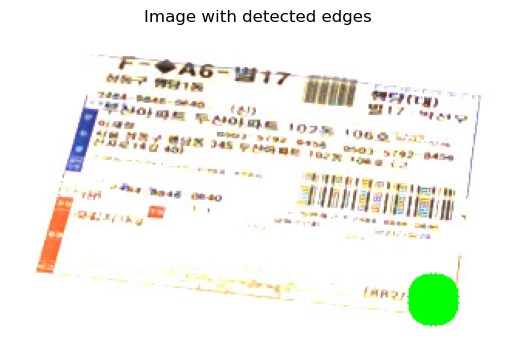

In [42]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def find_document_edges(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(gray, 75, 200)
    contours, _ = cv2.findContours(edged, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    for contour in contours:
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
        if len(approx) == 4:
            return approx
    return None

def calculate_area(points):
    contour = np.array(points).reshape((-1, 1, 2))
    area = cv2.contourArea(contour)
    return area

def calculate_area_ratio(area, image_shape):
    image_area = image_shape[0] * image_shape[1]
    area_ratio = area / image_area
    return area_ratio

# 테스트 이미지 로드
image_path = 'crops/invoice/CAM 20231028071200_5.jpg'
image = cv2.imread(image_path)
edges = find_document_edges(image)

if edges is not None:
    # 네 개의 점으로 컨투어링 한 사각형의 면적 계산
    area = calculate_area(edges)
    # 전체 이미지에서 사각형이 차지하는 비율 계산
    area_ratio = calculate_area_ratio(area, image.shape)
    print(f"Area of the detected quadrilateral: {area}")
    print(f"Ratio of the quadrilateral area to the entire image: {area_ratio:.2%}")

    # 이미지를 BGR에서 RGB로 변환 (matplotlib는 RGB 형식을 사용)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 모서리 점 표시
    for point in edges:
        cv2.circle(image, tuple(point[0]), 15, (0, 255, 0), -1)

    # 이미지를 matplotlib를 사용하여 표시
    plt.imshow(image)
    plt.title("Image with detected edges")
    plt.axis('off')  # 축을 숨깁니다.
    plt.show()
else:
    print("No quadrilateral detected.")


## 두 가지 컨투어링 방법 합친 코드

In [53]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def order_points(pts):
    # Initialize a list of coordinates that will be ordered
    rect = np.zeros((4, 2), dtype="float32")
    
    # The top-left point will have the smallest sum, the bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    # The top-right point will have the smallest difference, the bottom-left will have the largest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect

def find_document_edges(image):
    # 그레이스케일 변환
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # 가우시안 블러 적용
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Canny 에지 검출
    edged = cv2.Canny(blurred, 50, 150)
    
    # 닫기 연산을 위한 구조적 요소 생성 (5x5 크기의 사각형)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    
    # 닫기 연산 적용
    closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    image_area = image.shape[0] * image.shape[1]
    
    for contour in contours:
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
        if len(approx) == 4:
            rect = cv2.boundingRect(approx)
            contour_area = rect[2] * rect[3]
            if contour_area > 0.1 * image_area:
                return approx
    
    # 운송장 컨투어 찾기
    c = max(contours, key=cv2.contourArea)
    rect = cv2.minAreaRect(c)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    
     # box로 만들어지는 사각형 면적 계산
    width = rect[1][0]
    height = rect[1][1]
    box_area = width * height
    
    # 사각형 면적이 전체 이미지의 20%보다 작은 경우 걸러내기
    if box_area < 0.2 * image_area or box_area > 0.8 * image_area:
        return None
    
    return box

#이미지 내에서 문서의 가장자리를 기준으로 이미지를 변환(warp)
def warp_perspective(image, edges):
    pts = edges.reshape(4, 2) #edges는 4개의 점으로 이루어진 배열, reshape를 통해 (4,2)로 변환
    rect = order_points(pts) #사각형의 네 모서리의 점의 정확한 위치 찾기
    (tl, tr, br, bl) = rect
    maxWidth, maxHeight = image.shape[1], image.shape[0] #변환된 이미지의 너비와 높이는 입력 이미지의 크기로 설정
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight), flags=cv2.INTER_CUBIC) #cv2.INTER_CUBIC 보간법 사용하여 원근 변환 수행
    return warped #문서 이미지를 변환

# 이미지 로드
image_path = 'crops/invoice/CAM 20231028071050_5.jpg'
image = cv2.imread(image_path)

# 모서리 점 찾기
corners= find_document_edges(image)

if corners is not None:
    # 원근 변환 수행
    warped_image = warp_perspective(image, corners)

    # 모서리 점 출력
    print("Corners of the document:", corners)

    # 결과 이미지 출력
    plt.figure(figsize=(15, 15))

    plt.subplot(121)
    plt.title('Original Image')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    plt.subplot(122)
    plt.title('Warped Image')
    plt.imshow(cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB))

    plt.show()
else:
    print("The document area is less than 20% of the image area. Image discarded.")

The document area is less than 20% of the image area. Image discarded.
